# Giới thiệu về Hệ thống người giới thiệu: Hợp tác lọc

Sau khi tìm hiểu các mô hình hồi quy và phân loại cơ bản, các hệ thống recommmender có thể hoàn thành bộ ba của các cơ chế học tập cho khoa học dữ liệu.


Làm việc tại một công ty thương mại điện tử, tôi nghĩ rất nhiều về các hệ thống chuyên gia tư vấn và muốn giới thiệu các mô hình giới thiệu cơ bản. Mục tiêu của mô hình đề xuất là trình bày danh sách các đối tượng được xếp hạng cho một đối tượng đầu vào. Thông thường, thứ hạng này dựa trên sự tương tự giữa đối tượng đầu vào và các đối tượng được liệt kê. Để ít mơ hồ, người ta thường muốn hoặc là trình bày các sản phẩm tương tự với một sản phẩm nhất định hoặc các sản phẩm hiện tại được cá nhân đề nghị cho một người dùng nhất định.


Điều đáng ngạc nhiên là nếu có đủ dữ liệu người dùng sản phẩm (xếp hạng, mua hàng, v.v ...) thì không có thông tin nào khác cần thiết để đưa ra các đề xuất phù hợp. Điều này hoàn toàn khác so với hồi quy và các vấn đề phân loại, ở đó người ta phải khám phá các tính năng khác nhau để tăng cường năng lực tiên đoán của mô hình.


Đối với giới thiệu này, tôi sẽ sử dụng bộ dữ liệu MovieLens - tập dữ liệu cổ điển cho các mô hình giới thiệu đào tạo. Có thể lấy từ trang web của GroupLens. Có nhiều bộ dữ liệu khác nhau nhưng tôi sẽ sử dụng dưới đây bao gồm 100.000 xếp hạng phim của người dùng (trên thang 1-5). Tập tin dữ liệu chính bao gồm một danh sách được ngăn cách bằng thẻ với user-id (bắt đầu từ 1), id mục (bắt đầu từ 1), đánh giá và dấu thời gian như bốn trường. Chúng ta có thể sử dụng các lệnh bash trong máy tính xách tay Jupyter để tải tập tin xuống và đọc nó bằng pandas.


In [1]:
import numpy as np
import pandas as pd

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip

In [3]:
cd ml-100k/

/home/osboxes/Desktop/jupyter/ml-100k


In [4]:
ls

allbut.pl*        u1.base  u3.base  u5.base  ub.base  u.info
grid_search.cpkl  u1.test  u3.test  u5.test  ub.test  u.item
mku.sh*           u2.base  u4.base  ua.base  u.data   u.occupation
README            u2.test  u4.test  ua.test  u.genre  u.user


In [4]:
!head u.data
!echo # line break
!wc -l u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013

100000 u.data


In [5]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print str(n_users) + ' users'
print str(n_items) + ' items'

943 users
1682 items


Hầu hết các mô hình đề xuất bao gồm việc xây dựng một ma trận người dùng theo thứ tự với một số loại "tương tác" số trong mỗi tế bào. Nếu một trong số đó bao gồm xếp hạng số mà người dùng đưa ra, thì đây được gọi là mô hình phản hồi rõ ràng . Ngoài ra, người ta có thể bao gồm phản hồi ngầm mà đó là hành động của người dùng biểu thị sở thích tích cực hoặc tiêu cực cho một mục nhất định (chẳng hạn như xem mục trực tuyến). Hai kịch bản này thường phải được đối xử khác biệt.
Trong trường hợp bộ dữ liệu MovieLens, chúng tôi đã xếp hạng, vì vậy chúng tôi sẽ tập trung vào các mô hình phản hồi rõ ràng. Trước tiên, chúng ta phải xây dựng ma trận mục người sử dụng. Chúng ta có thể dễ dàng ánh xạ ID của người dùng / mục vào chỉ mục người dùng / mục bằng cách loại bỏ "Python bắt đầu ở 0" bù đắp giữa chúng.

In [11]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [12]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 6.30%


Trong bộ dữ liệu này, mỗi người dùng đã đánh giá ít nhất 20 bộ phim có kết quả khan hiếm là 6,3%. Điều này có nghĩa là 6,3% xếp hạng của người dùng có giá trị. Lưu ý rằng, mặc dù chúng ta điền vào các xếp hạng bị thiếu là 0, chúng ta không nên giả định các giá trị này thực sự là số không. Đúng hơn, chúng chỉ là các mục trống. Chúng tôi sẽ chia dữ liệu của chúng tôi thành các bộ đào tạo và thử nghiệm bằng cách xóa 10 xếp hạng cho mỗi người dùng từ tập huấn luyện và đưa chúng vào bộ kiểm tra.

In [14]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [18]:
train, test = train_test_split(ratings)

## Phối hợp lọc 

Chúng tôi sẽ tập trung vào các mô hình lọc cộng tác ngày nay, có thể được chia thành hai lớp: lọc dựa trên người dùng và dựa trên mục. Trong cả hai kịch bản, một trong những xây dựng một ma trận tương tự. Đối với lọc cộng tác dựa trên người dùng, ma trận tương tự người dùng sẽ bao gồm một số số liệu khoảng cách đo lường sự giống nhau giữa bất kỳ hai cặp người dùng nào. Tương tự, ma trận item-similarity sẽ đo sự tương tự giữa bất kỳ hai cặp item.


Một thước đo khoảng cách phổ biến là độ tương tự cosin. Số liệu có thể được nghĩ về hình học nếu người ta xử lý hàng (cột) của người dùng (của) người dùng cụ thể trong ma trận xếp hạng như một vector. Đối với lọc cộng tác dựa trên người dùng, độ tương đồng của hai người dùng được đo bằng cosin của góc giữa vectơ của hai người dùng. Đối với người dùng ${u}$ và ${u'}$, sự tương tự cosin là

$$
sim(u, u') = 
cos(\theta{}) = 
\frac{\textbf{r}_{u} \dot{} \textbf{r}_{u'}}{\| \textbf{r}_{u} \| \| \textbf{r}_{u'} \|} = 
\sum_{i} \frac{r_{ui}r_{u'i}}{\sqrt{\sum\limits_{i} r_{ui}^2} \sqrt{\sum\limits_{i} r_{u'i}^2} }
$$

Điều này có thể được viết như là một for-loop với mã, nhưng mã Python sẽ chạy khá chậm; Thay vào đó, người ta phải cố gắng thể hiện bất kỳ phương trình nào về chức năng NumPy. Tôi đã bao gồm một phiên bản chậm và nhanh chóng của chức năng tương tự cosin dưới đây. Chức năng chậm chạp kéo dài đến nỗi cuối cùng tôi đã hủy nó vì tôi đã quá mệt mỏi chờ đợi. Chức năng nhanh, mặt khác, mất khoảng 200 ms.

Độ tương tự cosin sẽ dao động từ 0 đến 1 trong trường hợp của chúng ta (vì không có xếp hạng âm). Lưu ý rằng nó là đối xứng và có những người dọc theo đường chéo.

In [19]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in xrange(ratings.shape[axmax]):
        for uprime in xrange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in xrange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [ ]:
#%timeit slow_similarity(train)

In [23]:
%timeit fast_similarity(train, kind='user')

1 loop, best of 3: 100 ms per loop


In [24]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print item_similarity[:4, :4]

[[ 1.          0.39094742  0.32210585  0.46132744]
 [ 0.39094742  1.          0.26181773  0.46642102]
 [ 0.32210585  0.26181773  1.          0.33177559]
 [ 0.46132744  0.46642102  0.33177559  1.        ]]


Với ma trận tương tự của chúng ta trong tay, bây giờ chúng ta có thể dự đoán các xếp hạng không được bao gồm trong dữ liệu. Sử dụng các dự đoán này, chúng tôi có thể so sánh chúng với dữ liệu thử nghiệm để cố gắng xác nhận chất lượng của mô hình người giới thiệu của chúng tôi.

Đối với lọc cộng tác dựa trên người dùng, chúng tôi dự đoán rằng xếp hạng $ u $ của người dùng cho khoản mục $ i $ được cho bởi tổng trọng số của tất cả xếp hạng của người dùng khác cho mục $ i $, trong đó trọng số là độ tương tự cosin giữa mỗi Người dùng và người dùng đầu vào $ u $.

$$\hat{r}_{ui} = \sum\limits_{u'}sim(u, u') r_{u'i}$$

Chúng ta cũng phải chuan hóa theo số lượng $ {r_ {u'i}} $ xếp hạng:

$$\hat{r}_{ui} = \frac{\sum\limits_{u'} sim(u, u') r_{u'i}}{\sum\limits_{u'}|sim(u, u')|}$$

Như với trước, tốc độ tính toán của chúng tôi sẽ được hưởng lợi rất nhiều bằng cách ưu tiên chức năng NumPy cho các vòng lặp. Với chức năng chậm của chúng tôi dưới đây, mặc dù tôi sử dụng các phương pháp NumPy, sự hiện diện của for-loop vẫn làm chậm các thuật toán

In [25]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in xrange(ratings.shape[0]):
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [17]:
%timeit predict_slow_simple(train, user_similarity, kind='user')

1 loop, best of 3: 33.7 s per loop


In [26]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

1 loop, best of 3: 85.4 ms per loop


Chúng tôi sẽ sử dụng chức năng bình phương bình phương scikit-learn như là thước đo xác nhận của chúng tôi. So sánh lọc cộng tác dựa trên người dùng và mục, có vẻ như bộ lọc cộng tác dựa trên người dùng cho chúng ta một kết quả tốt hơn.

In [27]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [28]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 8.3650185477
Item-based CF MSE: 11.4098225997


### Top-$k$ Collaborative Filtering

Chúng ta có thể cố gắng để cải thiện MSE dự đoán của chúng tôi bằng cách chỉ xem xét người dùng $ k $ hàng đầu tương tự như người sử dụng đầu vào (hoặc, tương tự, đầu $ k $). Đó là, khi chúng ta tính tổng trên $ u '$

$$\hat{r}_{ui} = \frac{\sum\limits_{u'} sim(u, u') r_{u'i}}{\sum\limits_{u'}|sim(u, u')|}$$

Chúng tôi chỉ tính tổng trên $ k $ hầu hết người dùng tương tự . Việc triển khai chậm của thuật toán này được trình bày dưới đây. Trong khi tôi chắc chắn rằng có một cách để sử dụng phân loại numpy để thoát khỏi đôi cho-vòng, tôi đã khá thất vọng desciphering đầu ra argsort 2D và chỉ cần giải quyết cho vòng chậm.

Như được hiển thị dưới đây, sử dụng phương pháp này thực sự một nửa sai lầm của chúng tôi!

In [33]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [36]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))

Top-k User-based CF MSE: 6.45457310569
Top-k Item-based CF MSE: 7.60866300971


Chúng tôi có thể thử điều chỉnh tham số $ k $ để tìm giá trị tối ưu để giảm thiểu MSE thử nghiệm của chúng tôi. Ở đây, nó thường giúp để hình dung các kết quả để có được một cảm giác cho những gì đang xảy ra.

In [37]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

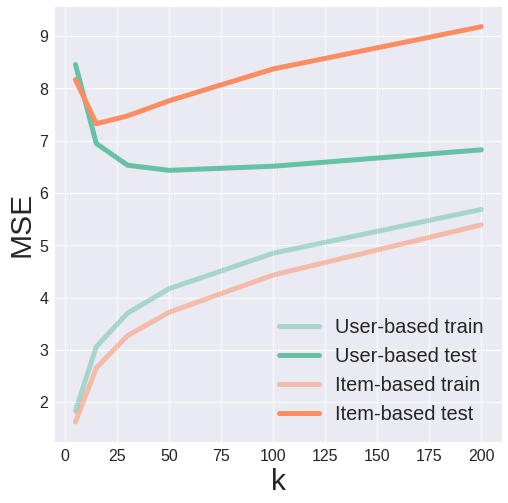

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

Dường như một k của 50 và 15 tạo ra một mức tối thiểu tốt đẹp trong lỗi kiểm tra cho lọc theo sự hợp tác của người dùng và sản phẩm, tương ứng.

## Bias-subtracted Collaborative Filtering 

Đối với phương pháp cuối cùng của chúng tôi về cải tiến các đề xuất, chúng tôi sẽ cố gắng loại bỏ những thành kiến ​​liên quan đến người dùng của mặt hàng. Ý tưởng ở đây là người dùng nhất định có xu hướng luôn cho xếp hạng cao hoặc thấp cho tất cả các bộ phim. Người ta có thể tưởng tượng rằng sự khác biệt tương đối trong xếp hạng mà những người dùng này cho là quan trọng hơn các giá trị đánh giá tuyệt đối .
Chúng ta hãy thử trừ đi mức đánh giá trung bình của mỗi người dùng khi tổng kết các xếp hạng của người dùng tương tự và sau đó thêm lại điểm trung bình đó vào cuối. Về mặt toán học, điều này có vẻ như


$$\hat{r}_{ui} = \bar{r_{u}} + \frac{\sum\limits_{u'} sim(u, u') (r_{u'i} - \bar{r_{u'}})}{\sum\limits_{u'}|sim(u, u')|}$$

Nơi $\bar{r_ {u}} $ là mức đánh giá trung bình của người dùng $ u $.

In [40]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [41]:
user_pred = predict_nobias(train, user_similarity, kind='user')
print 'Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test))

item_pred = predict_nobias(train, item_similarity, kind='item')
print 'Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test))

Bias-subtracted User-based CF MSE: 8.64369846442
Bias-subtracted Item-based CF MSE: 9.64862406044


Cuối cùng, chúng ta có thể thử kết hợp cả hai thuật toán Top- k và Bias-subtracted. Đáng kỳ lạ, điều này dường như thực sự tồi tệ hơn thuật toán Top- k gốc. Đi con số.

In [43]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [44]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

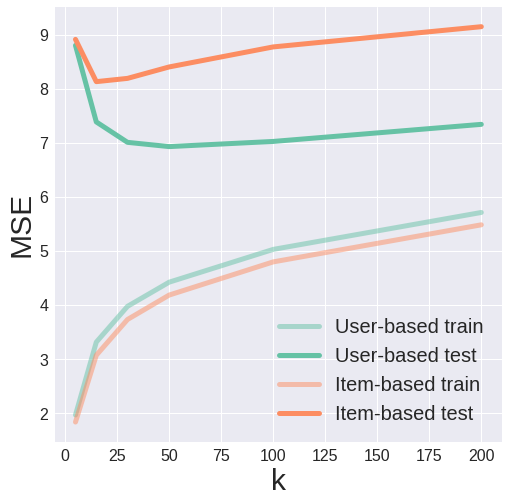

In [50]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

## Xác nhận 

Sau khi mở rộng theo thuật toán lọc cộng tác cơ bản, tôi đã chỉ ra cách chúng ta có thể giảm sai số bình phương trung bình của chúng ta với sự phức tạp của mô hình tăng lên. Tuy nhiên, làm thế nào chúng ta thực sự biết nếu chúng ta đang đưa ra các khuyến nghị tốt? Một điều mà tôi chú ý đến là sự lựa chọn của chúng tôi về số liệu tương tự. Làm thế nào để chúng ta biết rằng sự giống nhau cô sin là một thước đo tốt để sử dụng? Bởi vì chúng ta đang đối phó với một miền mà nhiều người trong chúng ta có trực giác (phim ảnh), chúng ta có thể nhìn vào ma trận tương tự mục và xem các mục tương tự "có ý nghĩa" hay không.

Và chỉ để vui vẻ, chúng ta hãy thực sự nhìn vào các mặt hàng. Bộ dữ liệu MovieLens chứa một tệp với thông tin về mỗi bộ phim. Nó chỉ ra rằng có một trang web gọi là themoviedb.org có một API miễn phí. Nếu chúng tôi có id phim IMDB "cho một bộ phim, sau đó chúng tôi có thể sử dụng API này để trả lại các áp phích phim. Xem tệp dữ liệu về phim dưới đây, có vẻ như chúng tôi ít nhất có URL IMDB cho mỗi bộ phim.

In [51]:
!head -5 u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0


Nếu bạn làm theo một trong các liên kết trong tập dữ liệu này, thì url của bạn sẽ được chuyển hướng. URL kết quả chứa ID phim IMDB là thông tin cuối cùng trong url bắt đầu bằng "tt". Ví dụ: url chuyển hướng cho Toy Story là http://www.imdb.com/title/tt0114709/ và ID phim IMDB là tt0114709.
Sử dụng thư viện Python yêu cầu, chúng tôi có thể tự động trích xuất ID phim này. Ví dụ Toy Story được hiển thị bên dưới.

In [52]:
import requests
import json

response = requests.get('http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)')
print response.url.split('/')[-2]

tt0114709


Tôi đã yêu cầu một khóa API miễn phí từ themoviedb.org. Chìa khóa là cần thiết để truy vấn API. Tôi đã bỏ qua nó dưới đây, vì vậy hãy nhớ rằng nếu bạn sẽ cần chìa khóa riêng của bạn nếu bạn muốn sao chép này. Chúng tôi có thể tìm kiếm các áp phích phim bằng id phim và sau đó lấy liên kết đến tệp hình ảnh. Liên kết là đường dẫn tương đối, vì vậy chúng tôi cần truy vấn base_url ở đầu ô tiếp theo để có được đường dẫn đầy đủ. Ngoài ra, một số liên kết không hoạt động, vì vậy chúng tôi có thể tìm kiếm phim theo tiêu đề và lấy kết quả đầu tiên.

In [60]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': '121641750d80c03d7d56d4ac26a7039e'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url):
    # Get IMDB movie ID
    response = requests.get(imdb_url)
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': '121641750d80c03d7d56d4ac26a7039e'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
        # print response.text
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['posters'][0]['file_path']
        
    return base_url + file_path

In [61]:
from IPython.display import Image
from IPython.display import display

toy_story = 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)'
Image(url=get_poster(toy_story, base_url))

Ta-da! Bây giờ chúng ta có một đường ống để đi trực tiếp từ url IMDB trong tệp dữ liệu để hiển thị người đăng phim. Với máy móc trong tay, chúng ta hãy điều tra ma trận tương tự phim của chúng ta.
Chúng ta có thể xây dựng một từ điển để lập bản đồ các chỉ số phim từ ma trận tương tự của chúng ta tới các url của các bộ phim. Chúng tôi cũng sẽ tạo một hàm helper để trả lại từ trên k phim tương tự như hầu hết các bộ phim đưa ra một số đầu vào. Với chức năng này, bộ phim đầu tiên quay trở lại sẽ là bộ phim đầu vào (vì tất nhiên nó gần giống nhất).

In [62]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [63]:
idx = 0 # Toy Story
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)

In [64]:
display(*posters)

Hmmm, những đề xuất không có vẻ quá tốt! Hãy nhìn vào một vài người nữa.

In [65]:
idx = 1 # GoldenEye
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [66]:
idx = 20 # Muppet Treasure Island
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [67]:
idx = 40 # Billy Madison
movies = top_k_movies(item_similarity, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

Như bạn thấy, có lẽ chúng ta đã không sử dụng một ma trận tương tự như nhau tốt tất cả cùng. Một số đề xuất này khá xấu - Star Wars là bộ phim tương tự nhất với Toy Story? Không có bộ phim James Bond nào trong 5 bộ phim hay nhất về GoldenEye?
Một điều có thể là vấn đề là các bộ phim rất phổ biến như Star Wars đang được ưa chuộng. Chúng ta có thể loại bỏ một số sự thiên vị này bằng cách xem xét một số liệu tương tự khác nhau - mối tương quan pearson. Tôi chỉ cần lấy các built-in scikit-tìm hiểu chức năng để tính toán này.

In [69]:
from sklearn.metrics import pairwise_distances
# Convert from distance to similarity
item_correlation = 1 - pairwise_distances(train.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0.

Let's look at these movies again.

In [71]:
idx = 0 # Toy Story
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [72]:
idx = 1 # GoldenEye
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [73]:
idx = 20 # Muppet Treasure Island
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

In [74]:
idx = 40 # Billy Madison
movies = top_k_movies(item_correlation, idx_to_movie, idx)
posters = tuple(Image(url=get_poster(movie, base_url)) for movie in movies)
display(*posters)

#### While the ordering changed some, we largely returned the same movies - now you can see why recommender systems are such a tricky beast! Next time we'll explore more advanced models and see how they affect the recommendations.

For the original IPython Notebook used to generate this post, click [here](https://github.com/EthanRosenthal/DataPiques_source/blob/master/content/notebooks/2015-11-02-intro-to-collaborative-filtering.ipynb)